# Data Understanding

## Koordinat Yang digunakan adalah Demak dan sekitarnya

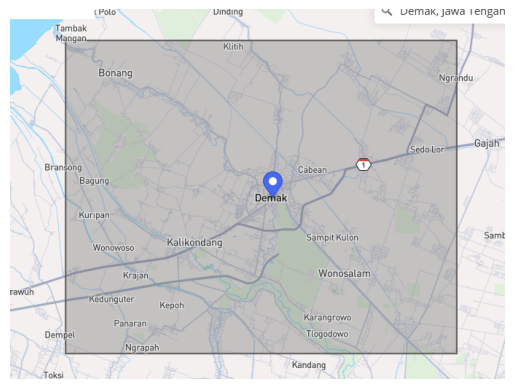

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path gambar kamu
img_path = r"D:\OneDrive\Pictures\Screenshots\koordinat_demak.png"

# Baca dan tampilkan
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off') 
plt.show()

## Mengambil data dan menyimpan ke dalam csv

In [2]:
import openeo
import pandas as pd
import matplotlib.pyplot as plt
import os

# 1️⃣ Koneksi ke Copernicus Data Space
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

# 2️⃣ AOI (Area of Interest): DEMAK dan sekitarnya
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [110.54853296172155, -6.826224927207619],
            [110.54853296172155, -6.962577241195746],
            [110.71997282462269, -6.962577241195746],
            [110.71997282462269, -6.826224927207619],
            [110.54853296172155, -6.826224927207619],
        ]
    ],
}

# 3️⃣ Ambil data Sentinel-5P (band "NO2") periode selama COVID
s5p = connection.load_collection(
    "SENTINEL_5P_L2",
    spatial_extent={
        "west": 110.54853296172155,
        "south": -6.962577241195746,
        "east": 110.71997282462269,
        "north": -6.826224927207619,
    },
    temporal_extent=["2020-06-01", "2021-06-30"],
    bands=["NO2"],
)

# 4️⃣ Mask nilai negatif (data invalid)
def mask_invalid(x):
    return x < 0

s5p_masked = s5p.mask(s5p.apply(mask_invalid))

# 5️⃣ Agregasi temporal harian
daily_mean = s5p_masked.aggregate_temporal_period(period="day", reducer="mean")

# 6️⃣ Agregasi spasial (rata-rata dalam AOI Demak)
daily_mean_aoi = daily_mean.aggregate_spatial(geometries=aoi, reducer="mean")

# 7️⃣ Jalankan batch job dan hasilkan file CSV
job = daily_mean_aoi.execute_batch(out_format="CSV")

# 8️⃣ Unduh hasil job
results = job.get_results()
results.download_files("no2_results")

# 9️⃣ Baca file CSV hasil
for f in os.listdir("no2_results"):
    if f.endswith(".csv"):
        df = pd.read_csv(os.path.join("no2_results", f))
        print("✅ File ditemukan:", f)
        break

# 🔟 Pastikan kolom tanggal benar
df["date"] = pd.to_datetime(df["date"])

# 11️⃣ Buat kolom bulan (YYYY-MM)
df["month"] = df["date"].dt.to_period("M")

# 12️⃣ Hitung rata-rata NO₂ per bulan
df_monthly = df.groupby("month", as_index=False)["NO2"].mean()

# 13️⃣ Visualisasi hasil
plt.figure(figsize=(10, 5))
plt.plot(df_monthly["month"].astype(str), df_monthly["NO2"], marker="o", color="blue", label="NO₂ Rata-rata per Bulan")
plt.title("Rata-rata Bulanan NO₂ (Sentinel-5P) di Demak dan sekitarnya")
plt.xlabel("Bulan")
plt.ylabel("Konsentrasi NO₂")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Authenticated using refresh token.


0:00:00 Job 'j-251102032250448b9ac37383e639416b': send 'start'


0:00:13 Job 'j-251102032250448b9ac37383e639416b': created (progress 0%)


KeyboardInterrupt: 

1. Koneksi ke Copernicus Data Space

Kode ini menggunakan library openeo untuk terhubung ke platform Copernicus Data Space, yaitu penyedia data satelit dari program Sentinel. Proses authenticate_oidc() digunakan untuk otentikasi agar pengguna bisa mengakses dan mengunduh data.

2. Menentukan AOI (Area of Interest)

AOI didefinisikan sebagai poligon yang menggambarkan batas geografis wilayah Demak dan sekitarnya menggunakan koordinat lintang dan bujur. Poligon ini menentukan area di mana data NO₂ akan diambil dari citra satelit.

3. Mengambil Data Sentinel-5P

Mengambil data satelit dari produk SENTINEL_5P_L2 dengan fokus pada band NO2, yaitu nitrogen dioksida — indikator utama kualitas udara. Data diambil untuk rentang waktu Juni 2020 hingga Juni 2021, yang mencakup masa pandemi COVID-19.

4. Masking Nilai Negatif (Data Invalid)

Nilai NO₂ negatif tidak valid secara fisik (karena konsentrasi gas tidak mungkin negatif). Oleh karena itu, fungsi mask_invalid() digunakan untuk memfilter dan menyingkirkan nilai-nilai tersebut.

5. Agregasi Temporal Harian

Data satelit biasanya tersedia per scene (tangkapan citra per waktu tertentu). Proses aggregate_temporal_period(period="day", reducer="mean") menghitung rata-rata nilai NO₂ setiap hari agar menghasilkan data dengan resolusi temporal harian.

6. Agregasi Spasial

Setelah data diolah secara temporal, langkah berikutnya menghitung rata-rata nilai NO₂ dalam seluruh area poligon Demak. Ini dilakukan dengan fungsi aggregate_spatial(), menghasilkan satu nilai rata-rata per hari untuk seluruh wilayah tersebut.

7. Eksekusi Batch Job & Ekspor ke CSV

Data hasil agregasi diolah di server Copernicus, kemudian hasilnya diekspor menjadi file CSV dengan perintah execute_batch(out_format="CSV").

8. Mengunduh Hasil ke Folder Lokal

Setelah job selesai, hasil unduhan CSV disimpan otomatis ke folder lokal bernama no2_results.

9. Membaca File CSV Hasil

Program mencari file hasil CSV dalam folder no2_results, membaca isinya menggunakan pandas, dan memuatnya ke dalam variabel df.

10. Konversi Kolom Tanggal

Kolom tanggal diubah ke format datetime agar dapat digunakan untuk analisis waktu, seperti membuat agregasi bulanan.

11. Menambahkan Kolom Bulan (YYYY-MM)

Dari tanggal harian, dibuat kolom baru berisi format periode bulanan untuk mempermudah perhitungan rata-rata tiap bulan.

12. Agregasi Bulanan

Mengelompokkan data berdasarkan bulan (groupby("month")) dan menghitung rata-rata NO₂ untuk setiap bulan.

13. Visualisasi Data

Grafik garis menampilkan tren perubahan rata-rata konsentrasi NO₂ per bulan di wilayah Demak.
Sumbu X menunjukkan waktu (bulan), dan sumbu Y menunjukkan konsentrasi NO₂. Visualisasi ini membantu memahami pola kualitas udara dalam periode yang diamati.